Step 1: Import Required Libraries

In [2]:
# Import necessary libraries
import pandas as pd
from interpreTS.utils.data_validation import validate_time_series_data
from interpreTS.utils.data_conversion import convert_to_time_series
from interpreTS.core.feature_extractor import FeatureExtractor, Features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# Version check for interpreTS
import interpreTS
print(f"Version: {interpreTS.__version__}")


Version: 0.4.1


Step 2: Load and Inspect the Data

In [3]:
# Load the data
df = pd.read_csv('data/radiator.csv')

# Convert the 'timestamp' column to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Preview the data
print(df.head())

# Get information about the dataset
df.info()

                           power
timestamp                       
2020-12-23 16:42:05+00:00    1.0
2020-12-23 16:42:06+00:00    1.0
2020-12-23 16:42:07+00:00    1.0
2020-12-23 16:42:08+00:00    2.5
2020-12-23 16:42:09+00:00    3.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2592001 entries, 2020-12-23 16:42:05+00:00 to 2021-01-22 16:42:05+00:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 39.6 MB


Step 3: Validate and Convert the Data

In [4]:
# Validate the time series data
try:
    validate_time_series_data(df)
    print("Time series data validation passed.")
except (TypeError, ValueError) as e:
    print(f"Validation error: {e}")

# Convert the data into interpreTS TimeSeriesData object
time_series_data = convert_to_time_series(df)

# Print the converted TimeSeriesData object and its underlying data
print(time_series_data)
print(time_series_data.data.head())

Time series data validation passed.
                           power
timestamp                       
2020-12-23 16:42:05+00:00    1.0
2020-12-23 16:42:06+00:00    1.0
2020-12-23 16:42:07+00:00    1.0
2020-12-23 16:42:08+00:00    2.5
2020-12-23 16:42:09+00:00    3.0


Step 4: Feature Extraction

In [5]:
# Initialize the FeatureExtractor
extractor = FeatureExtractor(
    features=[
        Features.MEAN, 
        Features.DOMINANT, 
        Features.TREND_STRENGTH, 
        Features.PEAK, 
        Features.VARIANCE
    ],
    window_size=60,  # Define the window size
    stride=30        # Define the stride
)

# Extract features from the time series data
features = extractor.extract_features(time_series_data.data)

# Display the extracted features
print(features.head())

   mean_power  dominant_power  trend_strength_power  peak_power  \
0  601.708333             1.0              0.755769      1314.0   
1  775.850000          1182.7              0.484017      1314.0   
2  176.033333             1.0              0.355786      1303.0   
3  380.816667             1.0              0.633966      1314.0   
4  808.200000          1182.8              0.009364      1314.0   

   variance_power  
0   421031.714336  
1   402910.943220  
2   194327.422599  
3   347499.270904  
4   359508.094915  


Step 5: Standardize the Features

In [6]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Print the shape of the scaled features
print(f"Scaled feature dimensions: {features_scaled.shape}")

Scaled feature dimensions: (86399, 5)


Step 6: Perform PCA Analysis

(a) Full PCA to Determine Optimal Number of Components

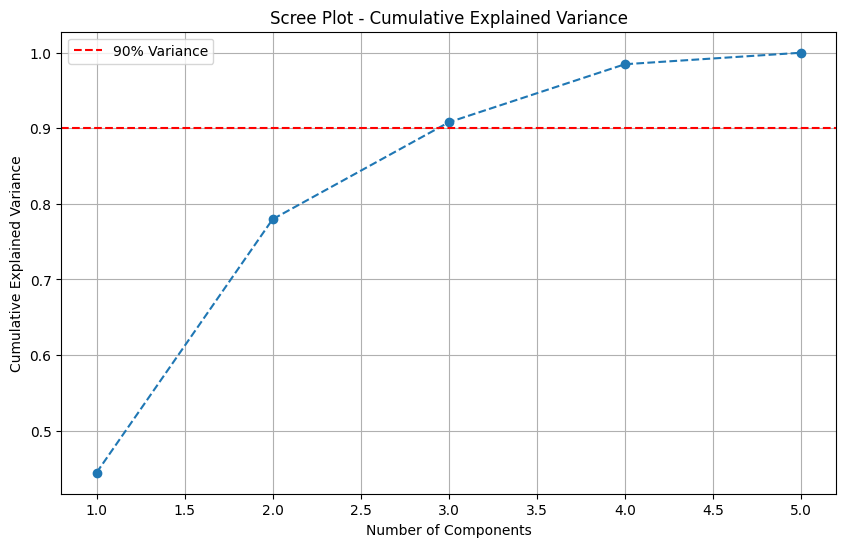

Number of components explaining at least 90% variance: 3


In [7]:
# Perform PCA with all components
pca = PCA()
pca_result = pca.fit_transform(features_scaled)

# Calculate the cumulative explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.title("Scree Plot - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

# Determine the number of components needed to explain 90% of the variance
n_components_90 = np.argmax(explained_variance_ratio >= 0.9) + 1
print(f"Number of components explaining at least 90% variance: {n_components_90}")


(b) Apply PCA with Selected Number of Components

In [8]:
# Perform PCA with the optimal number of components
pca_final = PCA(n_components=n_components_90)
pca_final_result = pca_final.fit_transform(features_scaled)

# Get the PCA loadings (coefficients)
loadings = pca_final.components_
loading_df = pd.DataFrame(
    loadings.T, 
    columns=[f"PC{i+1}" for i in range(n_components_90)], 
    index=features.columns
)

# Display the PCA loadings
print("\nPCA Loadings:")
print(loading_df)


PCA Loadings:
                           PC1       PC2       PC3
mean_power           -0.629927  0.181104  0.174236
dominant_power       -0.597785  0.165984  0.157005
trend_strength_power  0.008113 -0.590912  0.800670
peak_power           -0.492595 -0.366028 -0.351975
variance_power       -0.055940 -0.675646 -0.424303


Step 7: Visualize PCA Results

(a) 2D Scatter Plot of PCA Results

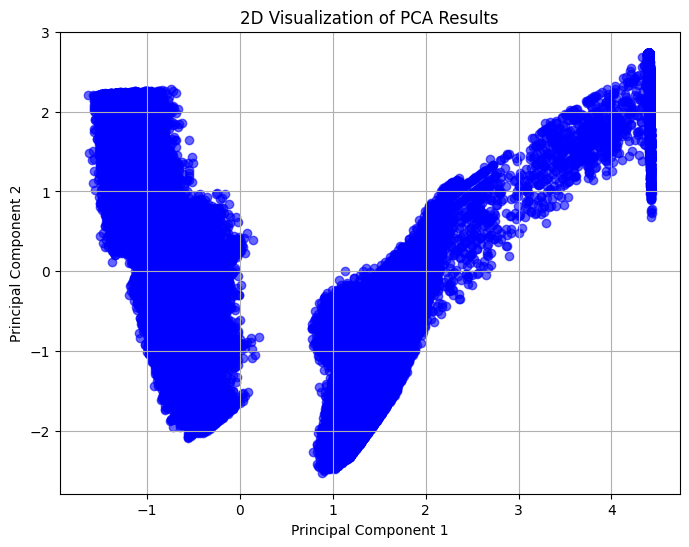

In [9]:
# Create a 2D scatter plot for the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_final_result[:, 0], pca_final_result[:, 1], c='blue', alpha=0.6)
plt.title("2D Visualization of PCA Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()


(b) 3D Scatter Plot of PCA Results

In [10]:
# Prepare data for 3D visualization
pca_df = pd.DataFrame(
    pca_final_result[:, :3],  # Only the first three components
    columns=["PC1", "PC2", "PC3"]
)

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color=None,  # Add a column with class labels if available
    opacity=0.7,
    title="3D Visualization of PCA Results",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"}
)

# Show the plot
fig.show()
